<a href="https://colab.research.google.com/github/BurEng354/FinForecast/blob/main/CI%2BMain%2BTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Directory 'From Burhan's Code' already created
Choose source of Stock Market Dataset (Device Storage/ Nasdaq API): Nasdaq API
Provide the DataBase Name from Nasdaq Data Link API (WIKI/): WIKI

Provide the Company Ticker from Nasdaq Data Link API (AAPL/MSFT): AAPL

Provide Temporal Data for the Stock Market Dataset: 

Please mention the Start Date (YYYY-MM-DD): 2007-01-01

Please mention the End Date (YYYY-MM-DD): 2018-01-01

Please mention the Interval between Timesteps (daily/monthly/annual): daily
Stock Market Dataset named AAPL.csv  is saved
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 3)                 0         
                                                                 
 dense_28 (Dense)            (None, 20)                80        
                                                                 
 dropout_14 (Dropout)        (N

'\nDeep Learning: LSTM\n'

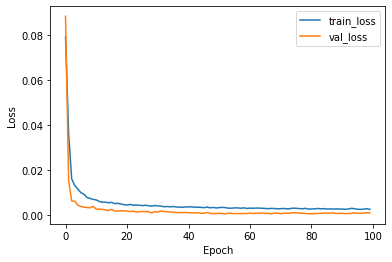

In [12]:
##################

##Script for the STOCK MARKET DATA STORAGE  (with Stock Market Feed Handler)

##################

##Financial Data Providers are: Google Finance Platform (from pandas) and
##Nasdaq Data Link Platform (using its API).

##################
!pip install nasdaq-data-link
import os
import nasdaqdatalink

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
#import talib ##https://github.com/mrjbq7/ta-lib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression

# import tensorflow as tf
# from tensorflow import keras
# from keras.layers import Dense, LSTM, Dropout, Input, Flatten
# from keras.models import Sequential
# from keras import callbacks

#import TS ##Trading Strategy Component

##Creating Project Directory for Stock Market Data Storage (use minimally due to Space Constraints)
Leaf_Directory = "From Burhan's Code"
Parent_Directory = 'C:\Group Project\Stock Market Datasets'
#Storage Path is Global
storage_path = os.path.join(Parent_Directory, Leaf_Directory)

try:
    os.makedirs(storage_path)
    print("Directory '%s' created successfully" % Leaf_Directory)
except OSError as error:
    print("Directory '%s' already created" % Leaf_Directory)
##error was defined for Error Handling


def historical_data_recorder_nasdaq():
    '''
    Configure the Nasdaq Data Link API and obtain a Stock Market Dataset from it 
    based on User Input at the Python Terminal. 
    
    Save said Dataset at the Project Directory (overwrite if needed).
    
    And finally, return the Dataframe of the Stock_Market_Dataset
    '''
    ##Configuring the Financial Data Providers for Historical Data Capturing (APIs and more...)
    api_key = "vZTqgD6CcX4SeDsExcCG"
    nasdaqdatalink.ApiConfig.api_key = api_key
    NASDAQ_DATA_LINK_API_KEY = api_key#GLobal
    
    ##Histoircal (Structured) Stock Market Data Capture
    ##Obtain User Input    
    database = input("Provide the DataBase Name from Nasdaq Data Link API (WIKI/): ")
    company_ticker = input("\nProvide the Company Ticker from Nasdaq Data Link API (AAPL/MSFT): ")
    DataLink_Code = database + '/' + company_ticker 
    
    print("\nProvide Temporal Data for the Stock Market Dataset: ")
    start = input("\nPlease mention the Start Date (YYYY-MM-DD): ")
    end = input("\nPlease mention the End Date (YYYY-MM-DD): ")
    interval_timesteps = input("\nPlease mention the Interval between Timesteps (daily/monthly/annual): ")#Frequency
    
    ##Using Detailed Guide
    #params={ 'start_date':start_date, 'end_date':end_date, 'collapse':interval_timesteps}
    #time_series = nasdaqdatalink.Dataset(DataLink_Code).data(params = params)
    #time_series.to_pandas()
     
    Stock_Market_Dataset = nasdaqdatalink.get(DataLink_Code, start_date = start, end_date = end, collapse = interval_timesteps)
    Stock_Market_Dataset.to_csv("C:\Group Project\Stock Market Datasets\From Burhan's Code\ %s.csv" % company_ticker)
    print ("Stock Market Dataset named %s.csv  is saved" % company_ticker)
    return Stock_Market_Dataset


def stock_market_dataset_preprocessor(dataset):
    '''
    Put in the Missing Data to make the Time Series regular (or let it remain irregular?) 
    https://www.ibm.com/docs/en/streams/5.3?topic=series-regular-irregular-time
    AI Forecaster presupposes what Stock Market Data will be on Holidays for Tehnical Reasons
    '''
    # 
    # dataset = dataset.set_index('Date')
    dataset = dataset.asfreq(freq ='1D')

    ##Dropping Volume and Adj. Volume
    #dataset = dataset.drop(['Volume', 'Adj. Volume'], axis = 1)
    dataset.head()
    
    ##Using Linear Interpolation (assuming Linear Relationship in a Series)
    imputed_dataset = pd.DataFrame()
    for column in dataset.columns:
        imputed_dataset[column] = dataset[column]
        imputed_dataset[column].interpolate(limit_direction = "both", inplace = True)

    ##Using MICE Imputer is not recommended (see line plot). Also, KNN Imputer gave similar results
    ##mice_imputer = IterativeImputer(estimator = LinearRegression(), missing_values = np.nan, max_iter = 30, imputation_order='roman')
    ##imputed_dataset = mice_imputer.fit_transform(dataset)#also removes Date column and gives a Numpy ndarray
    ##imputed_dataset = pd.DataFrame(imputed_dataset, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
    ##   'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'])   
    return dataset, imputed_dataset



'''
####################################################
SUNDAR, PLease add your Code in the following function
####################################################
'''

def TAA_Dataset_Transformer(dataset, col_n):
    '''
    Take in relevant varaible/column from the Stock Market Dataset and use the Techincal Analysis Algorithm (TAA) on it to form the
    Transformed Dataset. For an Undersranding of the Formulae of the TAIs use the Report
    '''
    price_var = dataset[col_n]
    t = 0 ##interation variable for for-loop below
    
    ##Initializing Lists to be Created and Parameters to be used in For-Loop
    History = []
    Dates = dataset.index.tolist()

    EMA = []
    n_EMA = 100 ##for EMA Calcultion
    sc_EMA = 2/(n_EMA+1) #sc = Smoothing Constant
    
    MOM = []
    n_MOM = 10

    BBANDS_mid = []
    BBANDS_upper = []
    BBANDS_lower = []
    Volatil_BBANDS = [] # difference b/w BBANDS_upper and BBANDS_lower 
    hist_BBANDS = []
    beta = 2
    std = 0
    
    for price in price_var:
        
        #For Plotting of Historical Stock Price Data
        History.append(price)
        
        #EMA LIST
        ##Older Prices will be preferred here as they capture Longer-term trends  
        ##and Bollinger Bands/ATR will cover, in a way, short-term "Volatility and Volatile Price Movements"
        if t == 0:
            EMA_val = price
        else:
            EMA_val = (price * sc_EMA) + ((1 - sc_EMA) * EMA_val)
        EMA.append(EMA_val)
        
        #MOMENTUM LIST
        if t >= n_MOM:
            MOM.append(price_var.iloc[t] - price_var.iloc[t - n_MOM])
        else:
            MOM.append(price_var.iloc[t] - price_var.iloc[0]) 
            ##Making a RULE for certain initial prices here
            
        #BBANDS LIST
        BBANDS_mid.append(EMA_val)
        if t < n_EMA:
            hist_BBANDS.append(price)
            std = np.std(hist_BBANDS)
            BBANDS_upper.append(EMA_val + beta*std)
            BBANDS_lower.append(EMA_val - beta*std)
            Volatil_BBANDS.append(2*beta*std)
        else:
            hist_BBANDS = []
            hist_BBANDS.extend(History[t-n_EMA : t])
            std = np.std(hist_BBANDS)
            BBANDS_upper.append(EMA_val + beta*std)
            BBANDS_lower.append(EMA_val - beta*std)            
            Volatil_BBANDS.append(2*beta*std)
        '''
        ###################################################
        ###################################################
        ###################################################
        SUNDAR, PLease add your Code here
        SUNDAR, PLease add your Code here
        SUNDAR, PLease add your Code here
        SUNDAR, PLease add your Code here
        SUNDAR, PLease add your Code here
        ###################################################
        '''
        t = t + 1 ##iteration variable is being incremeneted
    
    
    #Merge the TIAs Together into a DataFrame
    TAI_List_Zipped = list(zip(Dates, EMA, MOM, Volatil_BBANDS, History)) 
    TAI_Dataset = pd.DataFrame(TAI_List_Zipped, columns = ["Date", "EMA", "MOM", "Volatility_BBANDS", "Prices of Concern"])
    return History, price_var, TAI_Dataset#, EMA, MOM, Volatility_BBANDS

def TAI_Dataset_Preprocessor(dataset, ml_algo, modality):
    input_scaler = MinMaxScaler(feature_range = (0,1))
    output_scaler = MinMaxScaler(feature_range = (0,1))
    
    if ml_algo == "MLP" and modality == "Training":
        ##Splitting into Train and Test Sets
        input_train, input_test, output_train, output_test = train_test_split(
    dataset[["EMA", "MOM", "Volatility_BBANDS"]], dataset["Prices of Concern"], test_size = 0.1, shuffle = False)#Order needs to be maintained

        ##Scaling Input Sets
        input_train = input_train.values
        input_test = input_test.values
        
        input_train_scaled = input_scaler.fit_transform(input_train)##only learn from training data
        input_test_scaled = input_scaler.transform(input_test)

        ##Scaling the Output Sets 
        #output_train_scaled = output_train.values
        #output_test_scaled = output_test.values

        output_train = output_train.values.reshape(-1,1)
        output_test = output_test.values.reshape(-1,1)
        
        output_train_scaled = output_scaler.fit_transform(output_train)##only learn from training data
        output_test_scaled = output_scaler.transform(output_test)

        
    #if ml_algo == "LSTM":
        
    #if ml_algo == "RF":#RF is the ML Baseline for Deep Learning    

    return input_train_scaled, input_test_scaled, output_train_scaled, output_test_scaled, input_scaler, output_scaler ##Returning for Later Denomralization

'''
###############################################
###############################################
Main Code
'''

dataset_source = input("Choose source of Stock Market Dataset (Device Storage/ Nasdaq API): ")##Needs Error Handling due to User Input

if dataset_source == "Device Storage":##Work here
    Stock_Market_Dataset = pd.read_csv("C:\Group Project\Stock Market Datasets\From Burhan's Code\ AMZN.csv")
    Stock_Market_Dataset['Date'] = pd.to_datetime(Stock_Market_Dataset['Date'])
    Stock_Market_Dataset = Stock_Market_Dataset.set_index('Date')
    
if dataset_source == "Nasdaq API":
    Stock_Market_Dataset = historical_data_recorder_nasdaq()

S_M_Dataset_copy = Stock_Market_Dataset
SM_Dataset_MDPresent, S_M_Dataset_preprocessed = stock_market_dataset_preprocessor(S_M_Dataset_copy)
Price_History, Prices_Dataframe, TA_Indicators_Dataset = TAA_Dataset_Transformer(S_M_Dataset_preprocessed, 'Close')
TAIinput_train_scaled, TAIinput_test_scaled, TAIoutput_train_scaled, TAIoutput_test_scaled, ip_scalar, op_scalar = TAI_Dataset_Preprocessor(TA_Indicators_Dataset, "MLP", "Training")


'''
##Historical Data Plotting
##TAI Series Plotting
'''
##MICE Does not work according to this PLot
#close_plot = sns.lineplot(data = S_M_Dataset_preprocessed['Close'][:100])
#close_plot.set_xlabel("Timestep", fontsize = 10)


'''
Deep Learning: MLP
'''

num_TAIs = 3
#Overfitting the MLP first and then tuning it (Justify Architecture)
model_MLP = Sequential()
model_MLP.add(Flatten(input_shape=(num_TAIs, )) ) # we need to specify the input shape or we won't be able to see the summary
model_MLP.add(Dense(20, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(20, activation='relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(10, activation='relu'))
model_MLP.add(Dense(1, activation='sigmoid'))
model_MLP.summary()

#callback = callbacks.EarlyStopping(monitor='loss', patience=3) ## To prevent overfitting
model_MLP.compile(loss = 'mse', optimizer = 'Adam', metrics = ['mse'])
history_MLP = model_MLP.fit(TAIinput_train_scaled, TAIoutput_train_scaled, epochs = 100, validation_split = 0.222)


plt.plot(history_MLP.history['loss'], label='train_loss')
plt.plot(history_MLP.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

'''
Deep Learning: LSTM
'''
# model_LSTM = Sequential()
# model_LSTM.add(LSTM(20, input_shape = (TAI_Dataset_preprocessed['EMA'].count(), 5)))
# model_LSTM.add(Dense(1, activation='relu'))

# #model_MLP.summary()
# model_LSTM.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mae'])
# timesteps_C = input_train['EMA'].count()
# input_train = input_train.values.reshape(1, timesteps_C, num_TAIs)
# output_train = output_train.values 
# history_LSTM = model_LSTM.fit(input_train, output_train, epochs = 100)